In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 18.4MB/s 
     |████████████████████████████████| 3.2MB 53.4MB/s 
     |████████████████████████████████| 870kB 50.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=444654511f1430401fcb1bbf43a404b8e53d123c53b7fbf434b58241034d8417
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 19.0MB/s 


In [ ]:
import re
import pandas as pd
import numpy as np
import io
from google.colab import files
import os
import datetime
import time
import sys
import math
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration
import sentencepiece # Need for T5

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
import pandas as pd
#data = pd.read_csv('drive/My Drive/w266-final-project/data/data_augmented.csv')

full_data = pd.read_csv('drive/My Drive/w266-final-project/data/data_augmented_mda_no_numbers_labels.csv')

In [ ]:
full_data.shape

(43400, 17)

In [ ]:
full_data.head()

,ticker,name,sec_url,accepted_filing_date,trading_date_closest_to_filing_date,closing_price_on_filing_date,trading_date_7_days_after,opening_price_7_days_after,mda_raw_text_no_numbers,seven_day_percentage_change,binary_100,binary_105,binary_110,binary_120,trinary_90_110,trinary_95_105,trinary_98_102
0,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2017-11-14,2017-11-14,13.238575,2017-11-21,12.868580,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,0.972052,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2020-05-12,2020-05-12,9.800000,2020-05-19,10.300000,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.051020,1.0,1.0,0.0,0.0,1.0,2.0,2.0
2,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2020-02-11,2020-02-11,15.650000,2020-02-18,15.200000,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,0.971246,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2016-05-10,2016-05-10,12.162181,2016-05-17,12.204263,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.003460,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,BWL-A,BOWL AMERICA INC,https://www.sec.gov/Archives/edgar/data/13573/...,2016-02-09,2016-02-09,11.319373,2016-02-16,11.385911,OF FINANCIAL CONDITION AND RESULTS OF OPERATIO...,1.005878,1.0,0.0,0.0,0.0,1.0,1.0,1.0


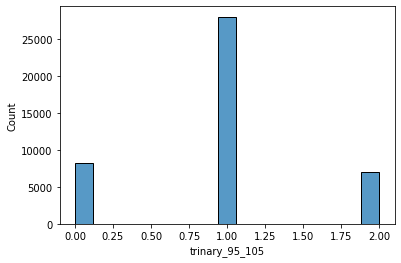

In [ ]:
# NO NEED TO RUN
## Creating Label 
#### 2 for percentage changes >= 102%
#### 1 for percentage changes between 98% and 102%
#### 0 for percentage changes below 98%

#data.loc[data.seven_day_percentage_change >= 1.05,"trinary_95_105"] = 2
#data.loc[(data.seven_day_percentage_change < 1.05) & (data.seven_day_percentage_change >= 0.95),"trinary_95_105"] = 1
#data.loc[data.seven_day_percentage_change < 0.95,"trinary_98_105"] = 0

import seaborn as sns
## plot histogram to check distribution of labels
sns.histplot(full_data.trinary_95_105)

In [ ]:
# Create a small dataset for testing model architecture (only first 100 rows of full data)
training_data = full_data[:100]
testing_data = full_data[100:120]

In [ ]:
print(training_data.shape)
print(testing_data.shape)

(100, 17)
(20, 17)


In [ ]:
# Separate train text and lables for small dataset

#train_texts, train_labels = training_data['mda_raw_text_no_numbers'], training_data['trinary_95_105']
#test_texts, test_labels = testing_data['mda_raw_text_no_numbers'], testing_data['trinary_95_105']

train_texts = training_data.mda_raw_text_no_numbers
train_labels = training_data.trinary_95_105

test_texts = testing_data.mda_raw_text_no_numbers
test_labels = testing_data.trinary_95_105

print(train_texts.shape)
print(train_labels.shape)
print(test_texts.shape)
print(test_labels.shape)

(100,)
(100,)
(20,)
(20,)


# T5 Fine Tuning Using PyTorch

In [ ]:
!pip install transformers
!pip install pytorch_lightning

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return True
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=labels,
    )

  def _step(self, batch):
    labels = batch["target_ids"]
    labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        labels=labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch=None, batch_idx=None, optimizer=None, optimizer_idx=None, optimizer_closure=None, on_tpu=None, using_native_amp=None, using_lbfgs=None):
    #if self.trainer.use_tpu:
    #  xm.optimizer_step(optimizer)
    #else:
    optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [ ]:
#DEBUG
data = pd.read_csv('drive/My Drive/w266-final-project/data/data_augmented_mda_no_numbers_labels.csv')

In [ ]:
#DEBUG - add labels
data.loc[data.seven_day_percentage_change >= 1.05,"trinary_95_105_text"] = 'positive'
data.loc[(data.seven_day_percentage_change < 1.05) & (data.seven_day_percentage_change >= 0.95),"trinary_95_105_text"] = 'neutral'
data.loc[data.seven_day_percentage_change < 0.95,"trinary_95_105_text"] = 'negative'

In [ ]:
#DEBUG - save new data file
data.to_csv (r'drive/My Drive/w266-final-project/data/market_data.csv', index = False)

In [ ]:
#DEBUG
import pandas as pd
data = pd.read_csv('drive/My Drive/w266-final-project/data/market_data.csv')

In [ ]:
df = data[:100]
df.to_csv (r'drive/My Drive/w266-final-project/data/market_data_toy_train.csv', index = False)

In [ ]:
class MarketDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    #self.path = os.path.join(data_dir, type_path + '.txt')
    self.data_column = "mda_raw_text_no_numbers"
    self.class_column = "trinary_95_105_text"
    self.data = pd.read_csv('drive/My Drive/w266-final-project/data/market_data_toy_train.csv')
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
#dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)
dataset = MarketDataset(tokenizer, 'market_data', 'train', 512)
len(dataset)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


100

In [ ]:
data = dataset[32]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS The following discussion and analysis is intended to help you understand our financial condition and results of operations for the three and nine months ended March,. You should read the following discussion and analysis together with our unaudited condensed consolidated financial statements and the notes to the condensed consolidated financial statements included under Item in this report, as well as the risk factors and other information included in our Annual Report and other reports and documents we file with the SEC. Our future financial condition and results of operations will vary from our historical financial condition and results of operations described below based on a variety of factors. Executive Overview The following overview does not address all of the matters covered in the other sections of this Item or other items in this report or contain all of the information that may be important to our stockholders or the investing

In [ ]:
!mkdir -p 'drive/My Drive/w266-final-project/data/t5_sentiment'

In [ ]:
args_dict.update({'data_dir': 'drive/My Drive/w266-final-project/data/', 'output_dir': 'drive/My Drive/w266-final-project/data/t5_sentiment', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/My Drive/w266-final-project/data/', 'output_dir': 'drive/My Drive/w266-final-project/data/t5_sentiment', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 2, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    #accumulate_grad_batches=args.gradient_accumulation_steps,
    accumulate_grad_batches=1,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    #early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return MarketDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
model = T5FineTuner(args)

In [ ]:
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


RuntimeError: ignored

#### Eval

In [ ]:
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [ ]:
for i, out in enumerate(outputs):
  if out not in ['positive', 'negative']:
    print(i, 'detected invalid prediction')

In [ ]:
metrics.accuracy_score(targets, outputs)

In [ ]:
print(metrics.classification_report(targets, outputs))